# Creating the Dataset from mesh files and solver times

In [103]:
import sys
print(sys.executable)


c:\Users\aol053\.conda\envs\mytorch\python.exe


In [104]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Dataset, Data
import meshio

In [105]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import contextlib # to suppress output

## Investigate the solving times DataFrame:

In [134]:
df = pd.read_csv("D:/ML4pmg/Data/solver_times.csv")
df.head()

,Mesh #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,0,gmres,ilu,ilu,True,33.0,0.002313,0.002193,0.004506,0.151635,gmres + ilu + ilu,0.004506
1,0,1,gmres,lu,ilu,True,8.0,0.004776,0.000730,0.005507,0.165953,gmres + lu + ilu,0.005507
2,0,2,gmres,sor,ilu,True,81.0,0.002156,0.005257,0.007413,0.137075,gmres + sor + ilu,0.007413
3,0,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,1.784661
4,0,4,gmres,bjacobi,ilu,True,33.0,0.006477,0.008921,0.015398,0.171397,gmres + bjacobi + ilu,0.015398


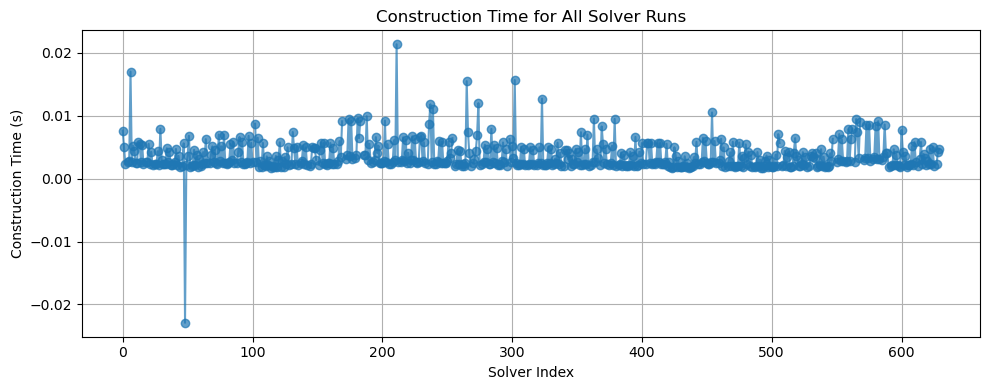

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(df["Construction Time (s)"].values, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Solver Index")
plt.ylabel("Construction Time (s)")
plt.title("Construction Time for All Solver Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Filter rows with negative construction time
bad_rows = df[df["Construction Time (s)"] < 0]

# Display them
print(bad_rows)


    Mesh #  Combination # KSP Type PC Mass PC Interface  Converged  \
48       2              6    gmres    gamg          ilu       True   

    Krylov Iters  Construction Time (s)  Solve Time (s)  Total Time (s)  \
48          16.0              -0.022933        0.001733         -0.0212   

    Tic Toc Time (s)        Solver Label  Adjusted Time (s)  
48          0.129581  gmres + gamg + ilu            -0.0212  


## Create the TriangleMeshDataset object 
Compare to the GNN_2606 version, here the nodes are the center of triangles


In [106]:
def compute_triangle_centers_and_features(coords, triangles):
    """
    Compute triangle centers, normalized areas, and internal angles.
    Returns:
        - centers: (n_triangles, 2) array with (x, y) for each triangle
        - features: (n_triangles, 4) array with normalized area and 3 normalized angles
    """
    centers = []
    features = []

    for tri in triangles:
        pts = coords[tri]  # shape (3, 2)
        center = np.mean(pts, axis=0)
        centers.append(center)

        # Side lengths
        a = np.linalg.norm(pts[1] - pts[0])
        b = np.linalg.norm(pts[2] - pts[1])
        c = np.linalg.norm(pts[0] - pts[2])
        s = 0.5 * (a + b + c)
        area = np.sqrt(max(s * (s - a) * (s - b) * (s - c), 1e-12))

        # Normalize area by dividing with triangle with largest possible area in the domain
        # This is local normalization per triangle (optional, but helps)
        # Or leave raw and normalize globally later
        # Here we store raw and normalize later

        # Angles using Law of Cosines, then normalize by π to get values ∈ [0, 1]
        A = np.arccos(np.clip((b**2 + c**2 - a**2) / (2 * b * c), -1.0, 1.0)) / np.pi
        B = np.arccos(np.clip((a**2 + c**2 - b**2) / (2 * a * c), -1.0, 1.0)) / np.pi
        C = 1.0 - A - B  # since sum = 1.0 after division by pi

        features.append([area, A, B, C])

    centers = np.array(centers, dtype=np.float32)
    features = np.array(features, dtype=np.float32)

    # Normalize area column to [0, 1] using min-max normalization
    areas = features[:, 0]
    min_area, max_area = areas.min(), areas.max()
    features[:, 0] = (areas - min_area) / (max_area - min_area + 1e-8)

    return centers, features

def build_triangle_adjacency(triangles):
    """
    Construct adjacency graph for triangles.
    Two triangles are connected if they share an edge.
    """
    from collections import defaultdict
    edge_to_tri = defaultdict(list)

    for i, tri in enumerate(triangles):
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for e in edges:
            e_sorted = tuple(sorted(e))
            edge_to_tri[e_sorted].append(i)

    edge_index = []
    for tri_list in edge_to_tri.values():
        if len(tri_list) == 2:
            i, j = tri_list
            edge_index.append((i, j))
            edge_index.append((j, i))  # bidirectional

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index


class TriangleMeshDataset(Dataset):
    def __init__(self, mesh_dir, csv_path, transform=None, pre_transform=None, log_transform=True):
        """
        mesh_dir: directory with .msh files
        csv_path: path to CSV file with solver timings
        log_transform: if True, applies -log(x+1e-6) to targets
        """
        super().__init__(mesh_dir, transform, pre_transform)
        self.mesh_dir = mesh_dir
        self.csv = pd.read_csv(csv_path)

        self.mesh_targets = self.csv.pivot_table(
            index='Mesh #',
            columns='Solver Label',
            values='Adjusted Time (s)'
        ).sort_index()

        if log_transform:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: max(0, -np.log(abs(x) + 1e-6)))


        self.mesh_ids = self.mesh_targets.index.tolist()
        self.solver_labels = self.mesh_targets.columns.tolist()

    def len(self):
        return len(self.mesh_ids)

    def get(self, idx):
        mesh_id = self.mesh_ids[idx]
        mesh_filename = f"mesh2d_7fr_{mesh_id:03d}.msh"
        mesh_path = os.path.join(self.mesh_dir, mesh_filename)

        mesh = meshio.read(mesh_path)
        coords = mesh.points[:, :2].astype(np.float32)  # take only x, y
        triangles = mesh.cells_dict.get("triangle")

        if triangles is None:
            raise ValueError(f"No triangle elements in {mesh_filename}")

        centers, triangle_feats = compute_triangle_centers_and_features(coords, triangles)
        x = torch.tensor(np.concatenate([centers, triangle_feats], axis=1), dtype=torch.float32)
        edge_index = build_triangle_adjacency(triangles)

        y_row = self.mesh_targets.loc[mesh_id].values.astype(np.float32)
        y = torch.tensor(y_row, dtype=torch.float32)

        data = Data(x=x, edge_index=edge_index, y=y)
        data.mesh_id = mesh_id
        return data

In [107]:
dataset = TriangleMeshDataset(
    mesh_dir="D:/ML4pmg/Data/",
    csv_path="D:/ML4pmg/Data/solver_times.csv"
)

print(f"Loaded {len(dataset)} graphs")
print(dataset[0])


Loaded 1000 graphs

Data(x=[718, 6], edge_index=[2, 2100], y=[21], mesh_id=0)


In [108]:
data = dataset[0]
print(data.y) 


tensor([5.5414, 5.5982, 4.7809, 5.5568, 5.1209, 5.2199, 5.3971, 5.3469, 4.1735,
        4.8813, 5.4021, 0.0000, 5.2016, 4.9044, 5.4432, 5.1526, 4.8481, 5.5150,
        5.0546, 4.4413, 4.9696])


## Visualize few samples in the dataset

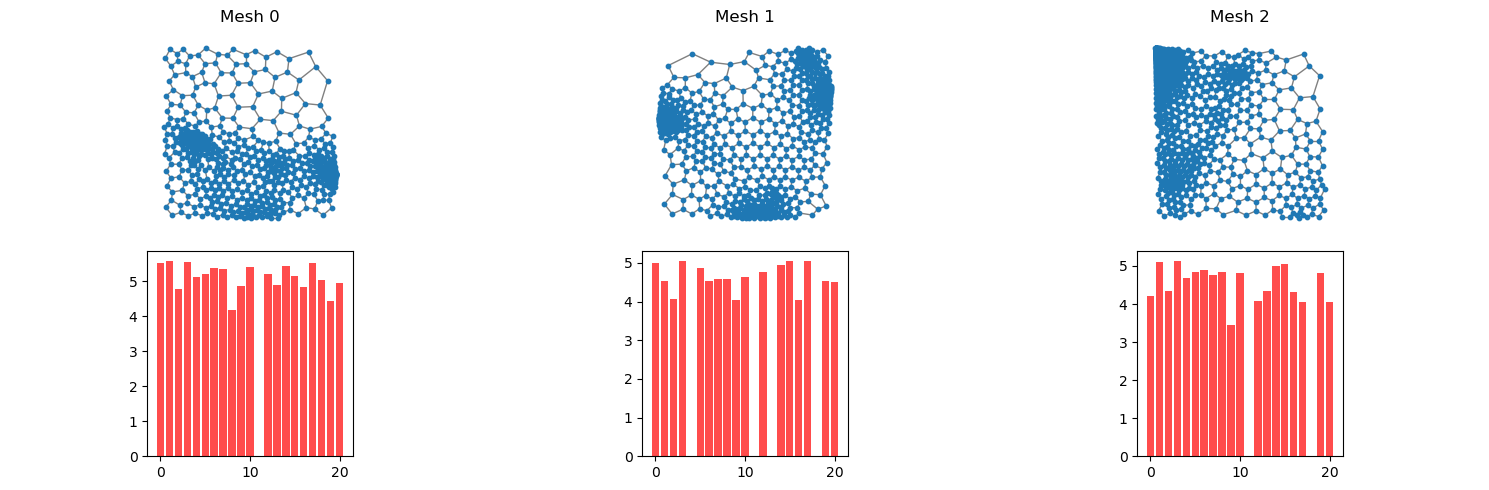

In [109]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y)),data.y.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()

## Create the model

Import needed packages

In [110]:
# For building the neural network
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# For data splitting and loading
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import random_split


# For training
import torch.optim as optim

## First (Simple) Model

In [111]:
class MeshSolverTimeNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim,hidden_dim)
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Graph convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling to get graph-level feature
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)  # Output: solver time vector
        return x


In [113]:
print("Node feature dim:", dataset[0].x.shape[1])
print("Target vector dim:", dataset[0].y.shape[0])



Node feature dim: 6

Target vector dim: 21


In [114]:
gnn_model = MeshSolverTimeNet(
    input_dim = 6,
    hidden_dim = 64,
    output_dim = 21
)

print(gnn_model)
num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

MeshSolverTimeNet(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
)
Number of trainable parameters: 10133


## Second (a bit more complex) Model

In [280]:

class GATNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(GATNet, self).__init__()
        
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads,dropout=0.2)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=0.2)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1,dropout=0.2)
        
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        
        x = global_mean_pool(x, batch)
        
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.lin2(x)
        #x = F.relu(x)
        return x


In [245]:
gnn_model = GATNet(
    input_dim=6,
    hidden_dim=64,
    output_dim=21
)

print(gnn_model)
num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

GATNet(
  (conv1): GATConv(6, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Number of trainable parameters: 28693


Split data and make dataset for single batch training

In [117]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define split sizes
total_len = len(dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# Merge all training graphs into one big batch
with contextlib.redirect_stdout(None):
    train_batch = Batch.from_data_list([train_dataset[i] for i in range(len(train_dataset))])
    test_batch = Batch.from_data_list([test_dataset[i] for i in range(len(test_dataset))])

In [118]:
for i in range(5):
    print(repr(train_dataset[i]))


Data(x=[1031, 6], edge_index=[2, 3040], y=[21], mesh_id=542)

Data(x=[796, 6], edge_index=[2, 2350], y=[21], mesh_id=618)

Data(x=[498, 6], edge_index=[2, 1444], y=[21], mesh_id=816)

Data(x=[905, 6], edge_index=[2, 2652], y=[21], mesh_id=68)

Data(x=[3308, 6], edge_index=[2, 9850], y=[21], mesh_id=94)


In [281]:
#gnn_model = MeshSolverTimeNet(
#    input_dim = 6,
#    hidden_dim = 64,
#    output_dim = 21
#)

gnn_model = GATNet(
    input_dim=6,
    hidden_dim=64,
    output_dim=21
)

print(gnn_model)
num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)


GATNet(
  (conv1): GATConv(6, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Number of trainable parameters: 28693


This needs to be fixed, the 'batch.y.view(-1,21)' is hard-coded now for both, train and evaluate

In [120]:
def train_full_batch(model, batch, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.batch)
    loss = criterion(out, batch.y.view(-1, 21))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_full_batch(model, batch, criterion):
    model.eval()
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, 21))

    return loss.item()


Lets make one forward pass to check!

In [247]:
data = dataset[0]
gnn_model.eval()  # set to evaluation mode
with torch.no_grad():
    batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)  # all nodes belong to graph 0
    output = gnn_model(data.x, data.edge_index, batch_vector)
print("Output shape:", output.shape)  # should be (1, 21)
print("Output:", output)


Output shape: torch.Size([1, 21])
Output: tensor([[ 0.0298,  0.0235, -0.0451, -0.0915, -0.0175, -0.0403,  0.0949,  0.1383,
         -0.0194, -0.0586, -0.0414, -0.0393,  0.1010,  0.0654,  0.0947, -0.0972,
          0.0838,  0.0003,  0.0005, -0.1251,  0.0075]])


## Train the model

In [282]:
train_losses = []
test_losses = []

In [ ]:
#optimizer = optim.SGD(gnn_model.parameters(), lr=0.01)

In [291]:
n_epochs =60
for epoch in range(1, n_epochs + 1):
    train_loss = train_full_batch(gnn_model, train_batch, optimizer, criterion)
    test_loss = evaluate_full_batch(gnn_model, test_batch, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


Epoch 001 | Train Loss: 2.3192 | Test Loss: 1.2623
Epoch 002 | Train Loss: 2.3266 | Test Loss: 1.2669
Epoch 003 | Train Loss: 2.3601 | Test Loss: 1.2788
Epoch 004 | Train Loss: 2.2307 | Test Loss: 1.2982
Epoch 005 | Train Loss: 2.2014 | Test Loss: 1.3237
Epoch 006 | Train Loss: 2.2179 | Test Loss: 1.3542
Epoch 007 | Train Loss: 2.2442 | Test Loss: 1.3843
Epoch 008 | Train Loss: 2.2403 | Test Loss: 1.4108
Epoch 009 | Train Loss: 2.2084 | Test Loss: 1.4301
Epoch 010 | Train Loss: 2.1433 | Test Loss: 1.4398
Epoch 011 | Train Loss: 2.1585 | Test Loss: 1.4395
Epoch 012 | Train Loss: 2.1606 | Test Loss: 1.4302
Epoch 013 | Train Loss: 2.1538 | Test Loss: 1.4138
Epoch 014 | Train Loss: 2.1414 | Test Loss: 1.3911
Epoch 015 | Train Loss: 2.1094 | Test Loss: 1.3664
Epoch 016 | Train Loss: 2.1528 | Test Loss: 1.3409
Epoch 017 | Train Loss: 2.1216 | Test Loss: 1.3169
Epoch 018 | Train Loss: 2.0713 | Test Loss: 1.2968
Epoch 019 | Train Loss: 2.0612 | Test Loss: 1.2809
Epoch 020 | Train Loss: 2.0481 

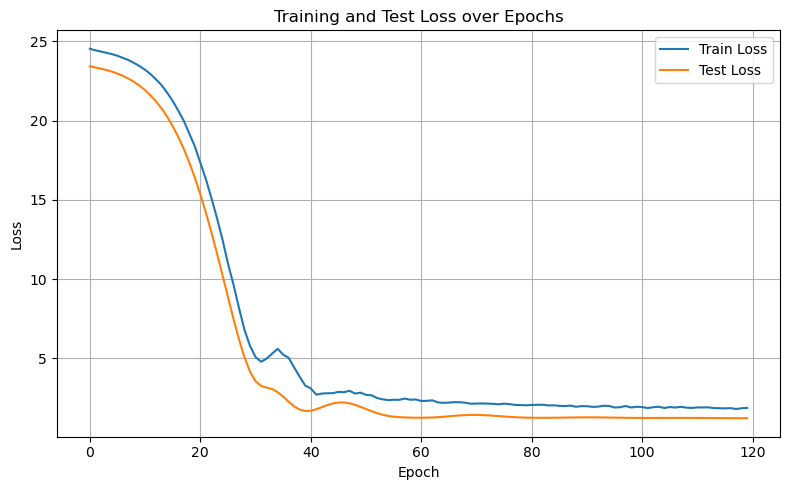

In [292]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


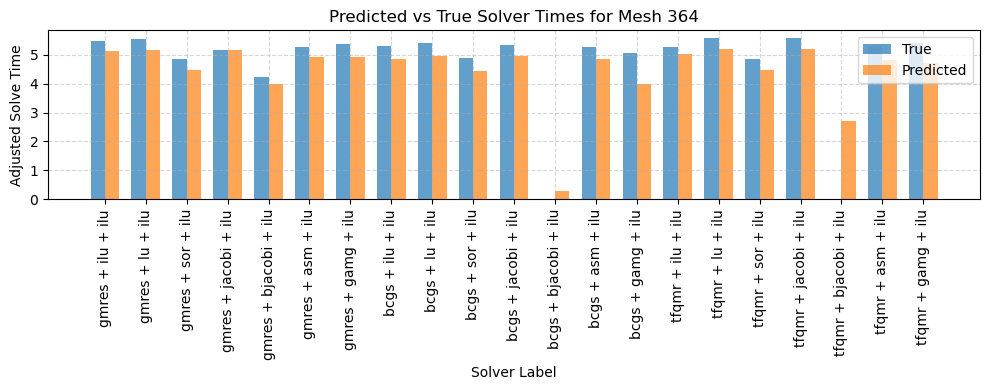

In [293]:

# Select one sample from test_dataset
data = test_dataset[5]

# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

# Model to eval mode
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze()
    y_true = data.y

# Convert to NumPy for plotting
y_pred = y_pred.numpy()
y_true = y_true.numpy()

# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_true))

labels = df['Solver Label'].values[0:21]

plt.bar([i - width/2 for i in indices], y_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_pred, width=width, label="Predicted", alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Solver Label")
plt.xticks(indices, labels, rotation=90)
plt.ylabel("Adjusted Solve Time")
plt.title(f"Predicted vs True Solver Times for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()


In [294]:
indx_pred = np.argmin(np.exp(-y_pred))
indx_true = np.argmin(np.exp(-y_true))



print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")
#print("---------------------------------------------------------------------------------")
#print(f"Predicted solver time for  {labels[indx_true]} is {np.exp(-y_pred[indx_true]):.5f}")
#print(f"True solver time for  {labels[indx_pred]} is {np.exp(-y_true[indx_pred]):.5f}")

Predicted solver: tfqmr + lu + ilu,   Total Time (s): 0.00553 // vs 0.00554
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.00384 // vs 0.00385



Predicted solver: tfqmr + lu + ilu,   Total Time (s): 0.00611 // vs 0.00631
True solver:      gmres + jacobi + ilu,   Total Time (s): 0.00480 // vs 0.00548

Predicted solver: tfqmr + lu + ilu,   Total Time (s): 0.00553 // vs 0.00561
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.00343 // vs 0.00347

Predicted solver: tfqmr + lu + ilu,   Total Time (s): 0.00688 // vs 0.00688
True solver:      tfqmr + lu + ilu,   Total Time (s): 0.00456 // vs 0.00456

Predicted solver: tfqmr + lu + ilu,   Total Time (s): 0.00572 // vs 0.00578
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.00367 // vs 0.00375


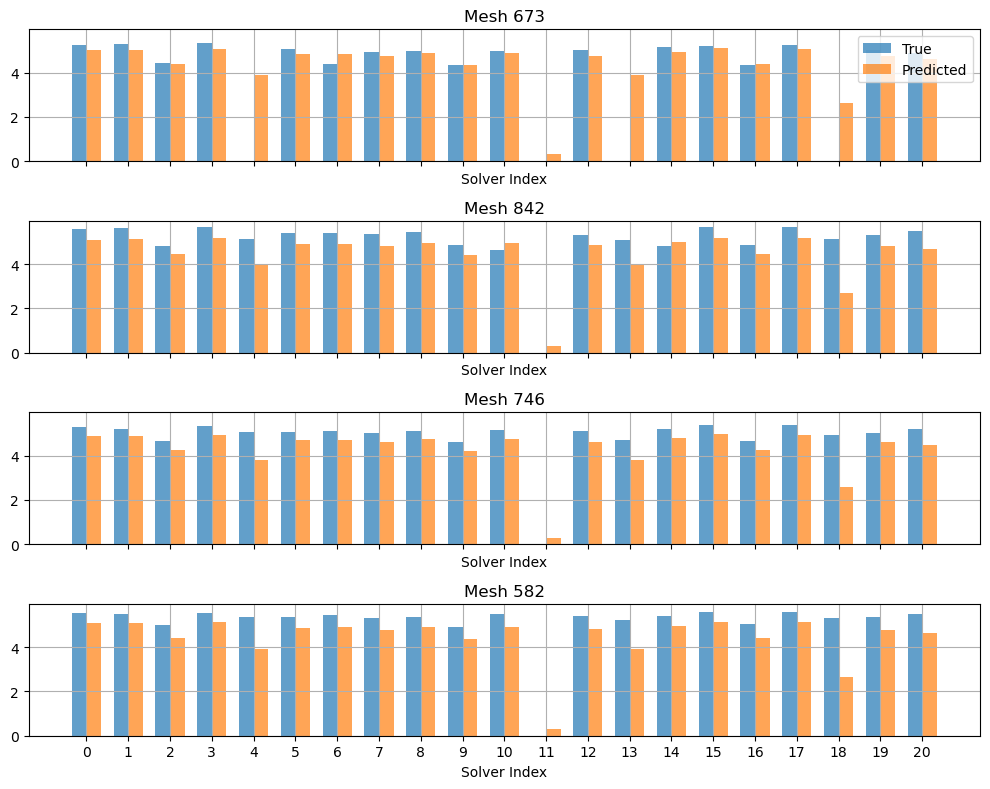

In [295]:
n = 4  # number of test samples to visualize

Y_pred, Y_true = [], []
fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n),sharex=True, sharey=True)

gnn_model.eval()
with torch.no_grad():
    for i in range(n):
        j = i
        data = test_dataset[j]
        batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

        y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze().numpy()
        y_true = data.y.numpy()
        
        Y_pred.append(y_pred)
        Y_true.append(y_true)

        ax = axes[i]
        width = 0.35
        indices = range(len(y_true))

        ax.bar([j - width/2 for j in indices], y_true, width=width, label="True", alpha=0.7)
        ax.bar([j + width/2 for j in indices], y_pred, width=width, label="Predicted", alpha=0.7)


        indx_pred = np.argmin(np.exp(-y_pred))
        indx_true = np.argmin(np.exp(-y_true))

        print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
        print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")

        ax.set_xlabel("Solver Index")
        ax.set_title(f"Mesh {data.mesh_id}")
        ax.set_xticks(indices)
        ax.grid(True)

    
    axes[0].legend()
    plt.tight_layout()
    plt.show()


### Accuracy for the training set

Correct best solver prediction in 118 out of 800 test cases,  14.75 % accuracy.


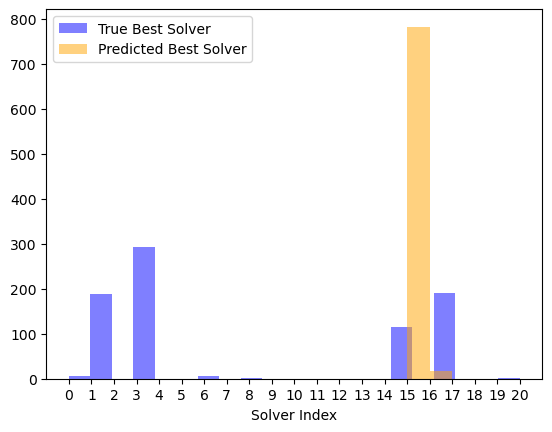

In [296]:
# Forward pass
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(train_batch.x, train_batch.edge_index, train_batch.batch).numpy()
    y_true = train_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases, {100*matches/total: .2f} % accuracy.")

plt.hist(true_best, bins=21, alpha=0.5, label='True Best Solver', color='blue' );
plt.hist(pred_best, bins=2, alpha=0.5, label='Predicted Best Solver', color='orange');
plt.xlabel('Solver Index')
plt.xticks(indices);
plt.legend()
plt.show()  

### Accurasy for the test set

Correct best solver prediction in 36 out of 200 test cases, 18.00 % accuracy.


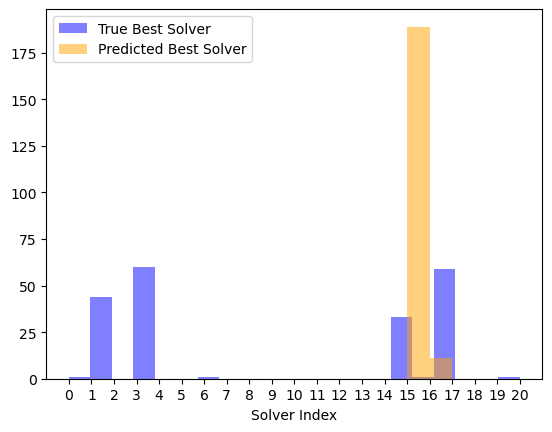

In [297]:
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(test_batch.x, test_batch.edge_index, test_batch.batch).numpy()
    y_true = test_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

aux = np.array(range(len(pred_best)))
dT_pp = y_pred_times[aux, pred_best] - y_pred_times[aux,true_best]
dT_tt = y_true_times[aux,pred_best] - y_true_times[aux,true_best]
dT_pt = y_pred_times[aux,pred_best] - y_true_times[aux,true_best]

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases,{100*matches/total: .2f} % accuracy.")


plt.hist(true_best, bins=21, alpha=0.5, label='True Best Solver', color='blue' );
plt.hist(pred_best, bins=2, alpha=0.5, label='Predicted Best Solver', color='orange');
plt.xlabel('Solver Index')
plt.xticks(indices);
plt.legend()
plt.show()  

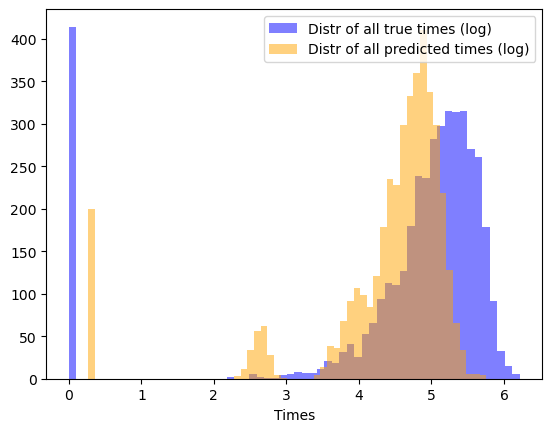

In [298]:
plt.hist(y_true.flatten(), bins=60, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.hist(y_pred.flatten(), bins=60, alpha=0.5, label='Distr of all predicted times (log)', color='orange');
plt.xlabel('Times')
plt.legend()
plt.show()